<a href="https://colab.research.google.com/github/florakth/DD2412-Project/blob/main/lrp_for_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and initialization

## See if there is a GPU available

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Imports

In [ ]:
import numpy as np
import tensorflow.keras
import sys
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121

import cv2
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.color import gray2rgb
from skimage.transform import resize

#from keras.models import load_model

In [ ]:
! git clone https://github.com/Jonrunar95/DD2412-Project.git
! ls

Cloning into 'DD2412-Project'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 350721 (delta 0), reused 1 (delta 0), pack-reused 350719
Receiving objects: 100% (350721/350721), 8.12 GiB | 43.42 MiB/s, done.
Resolving deltas: 100% (27/27), done.
DD2412-Project	sample_data


#MNIST and MLP

## MNIST Implementation

This part is referenced from the original github source

In [ ]:
def fetch_data():
    channels_first = K.image_data_format() == "channels_first"
    # the data, shuffled and split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if channels_first:
        x_train = x_train.reshape(60000, 1, 28, 28)
        x_test = x_test.reshape(10000, 1, 28, 28)
    else:
        x_train = x_train.reshape(60000, 28, 28, 1)
        x_test = x_test.reshape(10000, 28, 28, 1)

    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")

    return x_train, y_train, x_test, y_test


def create_preprocessing_f(X, input_range=[0, 1]):
    """
    Generically shifts data from interval [a, b] to interval [c, d].
    Assumes that theoretical min and max values are populated.
    """

    if len(input_range) != 2:
        raise ValueError(
            "Input range must be of length 2, but was {}".format(
                len(input_range)))
    if input_range[0] >= input_range[1]:
        raise ValueError(
            "Values in input_range must be ascending. It is {}".format(
                input_range))

    a, b = X.min(), X.max()
    c, d = input_range

    def preprocessing(X):
        # shift original data to [0, b-a] (and copy)
        X = X - a
        # scale to new range gap [0, d-c]
        X /= (b-a)
        X *= (d-c)
        # shift to desired output range
        X += c
        return X

    def revert_preprocessing(X):
        X = X - c
        X /= (d-c)
        X *= (b-a)
        X += a
        return X

    return preprocessing, revert_preprocessing

## Model building for MLPs

In [ ]:
num_classes = 10

data_not_preprocessed = fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)
x_train, y_train, x_test, y_test = data
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)
input_shape = (784,)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(Dense(400, input_shape=input_shape, activation='tanh') )
model.add(Dense(400, activation='tanh'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])  #adam or sgd?
history = model.fit(x_train, y_train, epochs=10, batch_size=128)  # mabbe need to change some parameters acorrding to the paper
score = model.evaluate(x_test, y_test, verbose=0)

## Sanity Check

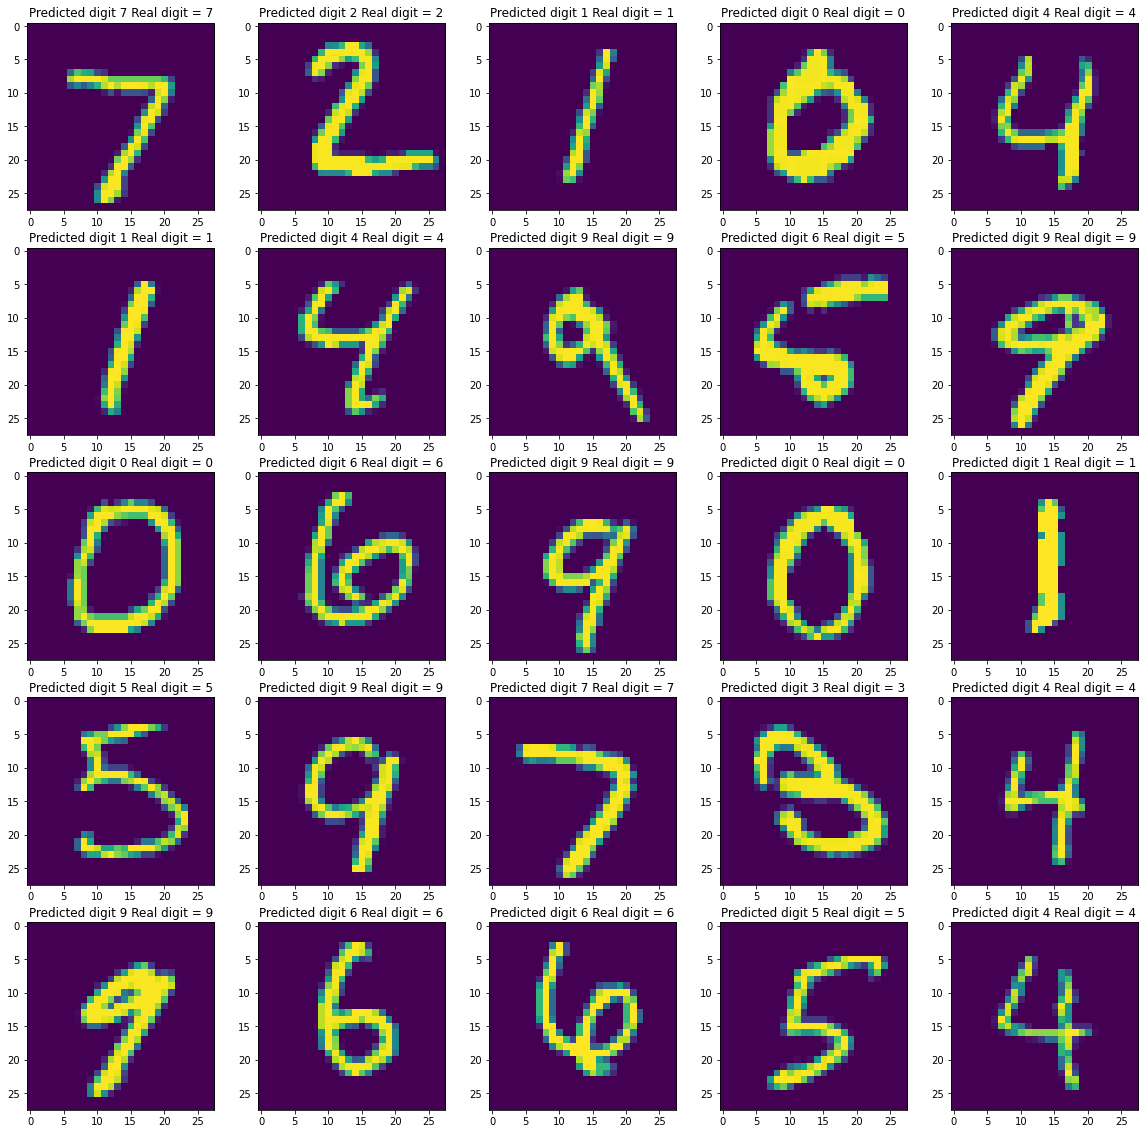

In [ ]:
input = x_test[:25, :]

y_pred = model.predict(input)

fig=plt.figure(figsize=(20, 20))

for i in range(0, 25):
  ax1 = fig.add_subplot(5, 5, i+1)
  ax1.imshow(input[i].reshape(28, 28))
  ax1.title.set_text("Predicted digit " + str(np.argmax(y_pred[i])) + " Real digit = " + str(np.argmax(y_test[i])))

plt.show()

# Load data from Github

In [ ]:
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 14

ZEROS = True
ONES = False

In [ ]:
testCSV = np.loadtxt("DD2412-Project/CheXpert-v1.0-small/valid.csv", delimiter=",", dtype=str)

testPaths = testCSV[1:, 0]
test_labels = testCSV[1:, 5:]

print(testPaths.shape, test_labels.shape)

x_test = np.zeros((testPaths.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

for i in range(testPaths.shape[0]):
    image = Image.open("DD2412-Project/" + testPaths[i])
    image_array = np.asarray(image.convert("RGB"))
    image_array = image_array / 255.
    x_test[i] = resize(image_array, IMAGE_SIZE)

test_labels[test_labels == '1.0'] = '1'
test_labels[test_labels == ''] = '0'
test_labels[test_labels == '0.0'] = '0'
if ZEROS:
  test_labels[test_labels == '-1.0'] = '0'
else:
  test_labels[test_labels == '-1.0'] = '1'
y_test = np.asarray(test_labels, dtype = int)

print(x_test.shape, y_test.shape)


(234,) (234, 14)
(234, 224, 224, 3) (234, 14)


# Grad-CAM

In [ ]:
# adapted from https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/?fbclid=IwAR3mV62vSMoE2LIB77EPHaLc-cyeNnO_cz9xTliYWyMP9jgbFA2fGeVaOJw 
#          and https://colab.research.google.com/drive/1098Hp2icvleIQelkaLmPoIqAKuahs7JH#scrollTo=BUGkcv9c-1m2
def find_target_layer(model):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(model.layers):
        # check to see if the layer has a 4D output
        if len(layer.output_shape) == 4:
            return layer.name

    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

def GradCam(model, classIdx, image, layerName=None, eps=1e-8):
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    # Create a graph that outputs target convolution and output
    if layerName is None:
        layerName = find_target_layer(model)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layerName).output, model.output])
    # Get the score for target class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, classIdx]

    # Extract filters and gradients
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    # Apply guided backpropagation
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads

    # Average gradients spatially
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    # Build a ponderated map of filters according to gradients importance
    cam = np.ones(output.shape[0:2], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, :, index]
    # Heatmap visualization
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min() +eps)
    # return the resulting heatmap to the calling function
    return heatmap

In [ ]:
def transparent_cmap(cmap, N=255):
  "Copy colormap and set alpha values"

  mycmap = cmap
  mycmap._init()
  mycmap._lut[:,-1] = np.linspace(0, 0.4, N+4)
  return mycmap

def plot_GradCAM(heatmap, x1):
  w, h = heatmap.shape
  y, x = np.mgrid[0:h, 0:w]   
  mycmap = transparent_cmap(plt.cm.Reds)
  fig, ax = plt.subplots(1, 1)
  ax.imshow(x1, cmap='gray')
  cb = ax.contourf(x, y, heatmap, 2, cmap=mycmap)
  plt.colorbar(cb)
  plt.show()

#Transfer Learning

In [ ]:
num_classes = 14

inp = layers.Input(shape=(224, 224, 3))
model = tf.keras.applications.DenseNet121(include_top=True, weights="DD2412-Project/weightsBest.h5", input_tensor=inp, input_shape=(224, 224, 3), classes=num_classes)

(1, 224, 224, 3)


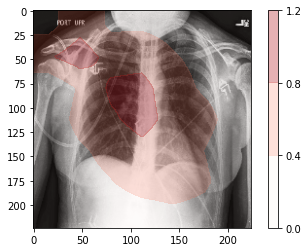

In [ ]:

x1 = x_test[[200]]
print(x1.shape)
predictions = model.predict(x1)
pred = np.argmax(predictions)

heatmap = GradCam(model, pred, x1)
plot_GradCAM(heatmap, x1[0])